In [11]:
# Install all required packages
%pip install tensorflow matplotlib seaborn scikit-learn numpy pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
# Import core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Keras model and layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential, Model, load_model # type: ignore
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0 # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Display version info
print("TensorFlow version:", tf.__version__)
print("GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.get_logger().setLevel('ERROR')

TensorFlow version: 2.20.0
GPUs Available: 0


In [13]:
# This function prepares the image data from folders
# It performs rescaling and augmentation for the training set
# and only rescaling for the validation set.

def create_data_generators(train_dir='data/train', val_dir='data/val', img_size=(224, 224), batch_size=32):
    """Creates train and validation data generators."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,            # Normalize pixel values to [0,1]
        rotation_range=20,         # Random rotation
        zoom_range=0.2,            # Random zoom
        width_shift_range=0.2,     # Horizontal shift
        height_shift_range=0.2,    # Vertical shift
        horizontal_flip=True,      # Flip images horizontally
        validation_split=0.2       # Reserve part of the training data for validation
    )

    # Training data
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    # Validation data
    val_gen = train_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    # Display basic information
    print(f"Classes: {train_gen.class_indices}")
    print(f"Train Samples: {train_gen.samples}, Validation: {val_gen.samples}")

    return train_gen, val_gen

# Create generators
train_gen, val_gen = create_data_generators('data/train', 'data/val')


Found 4984 images belonging to 11 classes.
Found 215 images belonging to 11 classes.
Classes: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}
Train Samples: 4984, Validation: 215


In [14]:
# Simple CNN architecture for baseline performance
# It consists of 3 convolutional blocks followed by dense layers

def build_cnn_model(num_classes):
    """Builds and compiles a simple CNN model."""
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [15]:
# This function handles model training and saves the best checkpoint automatically.

def train_model(model, train_gen, val_gen, model_name='model', epochs=10):
    os.makedirs("models", exist_ok=True)

    checkpoint = ModelCheckpoint(
        f"models/{model_name}_best.h5", monitor='val_accuracy',
        save_best_only=True, mode='max', verbose=1
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, early_stop], verbose=1)

    # Plot accuracy and loss graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title(f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title(f'{model_name} Loss')
    plt.show()

    return model, history


In [16]:
# This function builds a transfer learning model using one of the popular pretrained architectures.
# use weights from ImageNet and add custom dense layers for our fish dataset.

def build_pretrained_model(base_model_name, num_classes):
    """Builds a transfer learning model with the given base architecture."""
    base_models = {
        "VGG16": VGG16,
        "ResNet50": ResNet50,
        "MobileNetV2": MobileNetV2,
        "InceptionV3": InceptionV3,
        "EfficientNetB0": EfficientNetB0
    }

    # Load base model
    base = base_models[base_model_name](weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze base model layers initially
    for layer in base.layers:
        layer.trainable = False

    # Add custom classification layers
    x = Flatten()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [17]:
# Evaluates model performance on validation data
# Displays accuracy, classification report, and confusion matrix

def evaluate_model(model, val_gen):
    val_loss, val_acc = model.evaluate(val_gen)
    print(f"Validation Accuracy: {val_acc:.4f}")

    y_pred = np.argmax(model.predict(val_gen), axis=1)
    y_true = val_gen.classes
    labels = list(val_gen.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return val_acc, val_loss


In [18]:
# This function:
# 1. Trains CNN and all pretrained models
# 2. Compares their accuracy
# 3. Automatically fine-tunes the best performing model

def compare_models(train_gen, val_gen):
    models_dict = {
        "CNN": build_cnn_model(train_gen.num_classes),
        "VGG16": build_pretrained_model("VGG16", train_gen.num_classes),
        "ResNet50": build_pretrained_model("ResNet50", train_gen.num_classes),
        "MobileNetV2": build_pretrained_model("MobileNetV2", train_gen.num_classes),
        "InceptionV3": build_pretrained_model("InceptionV3", train_gen.num_classes),
        "EfficientNetB0": build_pretrained_model("EfficientNetB0", train_gen.num_classes)
    }

    results = {}
    for name, model in models_dict.items():
        print(f"\n============================")
        print(f"Training {name} model...")
        print("============================")
        train_model(model, train_gen, val_gen, model_name=name.lower(), epochs=5)
        acc, loss = evaluate_model(model, val_gen)
        results[name] = {'accuracy': acc, 'loss': loss}

    # Compare validation accuracy of all models
    names = list(results.keys())
    accs = [v['accuracy'] for v in results.values()]
    plt.figure(figsize=(10, 6))
    plt.bar(names, accs, color='skyblue')
    plt.title("Model Accuracy Comparison")
    plt.xlabel("Model")
    plt.ylabel("Validation Accuracy")
    plt.ylim(0, 1)
    plt.show()

    # Select best model
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    print(f"\nBest Model: {best_model_name} ({results[best_model_name]['accuracy']*100:.2f}% accuracy)")

    # Fine-tune only if the best model is pretrained
    if best_model_name != "CNN":
        fine_tune_model = load_model(f"models/{best_model_name.lower()}_best.h5")

        # Unfreeze top layers
        for layer in fine_tune_model.layers[-30:]:
            layer.trainable = True

        fine_tune_model.compile(optimizer=Adam(learning_rate=1e-5),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

        print(f"\nFine-tuning {best_model_name}...")
        fine_tune_model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)

        fine_tune_model.save("models/final_best_model_finetuned.h5")
        print("Fine-tuned model saved as final_best_model_finetuned.h5")

    else:
        print("Best model is CNN — skipping fine-tuning.")

    return results


Found 4984 images belonging to 11 classes.
Found 215 images belonging to 11 classes.
Classes: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}
Train Samples: 4984, Validation: 215

Training CNN model...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2287 - loss: 2.3536
Epoch 1: val_accuracy improved from None to 0.44186, saving model to models/cnn_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.3118 - loss: 1.9694 - val_accuracy: 0.4419 - val_loss: 1.5543
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4424 - loss: 1.5452
Epoch 2: val_accuracy improved from 0.44186 to 0.54884, saving model to models/cnn_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4831 - loss: 1.4478 - val_accuracy: 0.5488 - val_loss: 1.1351
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5409 - loss: 1.2456
Epoch 3: val_accuracy improved from 0.54884 to 0.68372, saving model to models/cnn_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5524 - loss: 1.2046 - val_accuracy: 0.6837 - val_loss: 0.9102
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5914 - loss: 1.1088 
Epoch 4: val_accuracy improved from 0.68372 to 0.70233, saving model to models/cnn_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1606s 10s/step - accuracy: 0.6035 - loss: 1.0924 - val_accuracy: 0.7023 - val_loss: 0.8490
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.6541 - loss: 0.9500
Epoch 5: val_accuracy did not improve from 0.70233
156/156 ━━━━━━━━━━━━━━━━━━━━ 156s 1000ms/step - accuracy: 0.6441 - loss: 0.9699 - val_accuracy: 0.6977 - val_loss: 0.8652


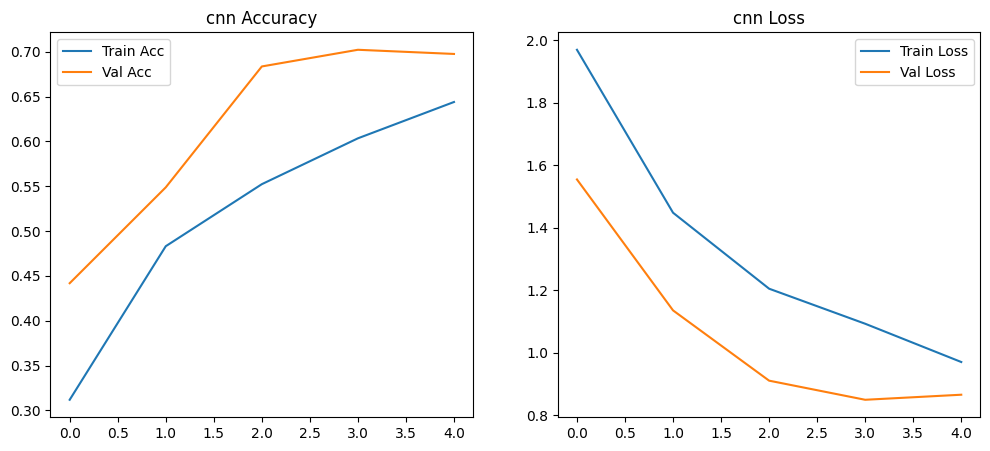

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.7023 - loss: 0.8547
Validation Accuracy: 0.7023


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.12      0.14      0.13        37
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.14      0.14      0.14        21
   fish sea_food gilt_head_bream       0.00      0.00      0.00        18
   fish sea_food hourse_mackerel       0.00      0.00      0.00        19
        fish sea_food red_mullet       0.00      0.00      0.00        18
     fish sea_food red_sea_bream       0.00      0.00      0.00        22
          fish sea_food sea_bass       0.29      0.21      0.24        19
            fish sea_food shrimp       0.05      0.05      0.05        20
fish sea_food striped_red_mullet       0.12      0.10      0.11        20
             fish sea_food trout       0.20      0.42      0.27        19

                        accuracy               

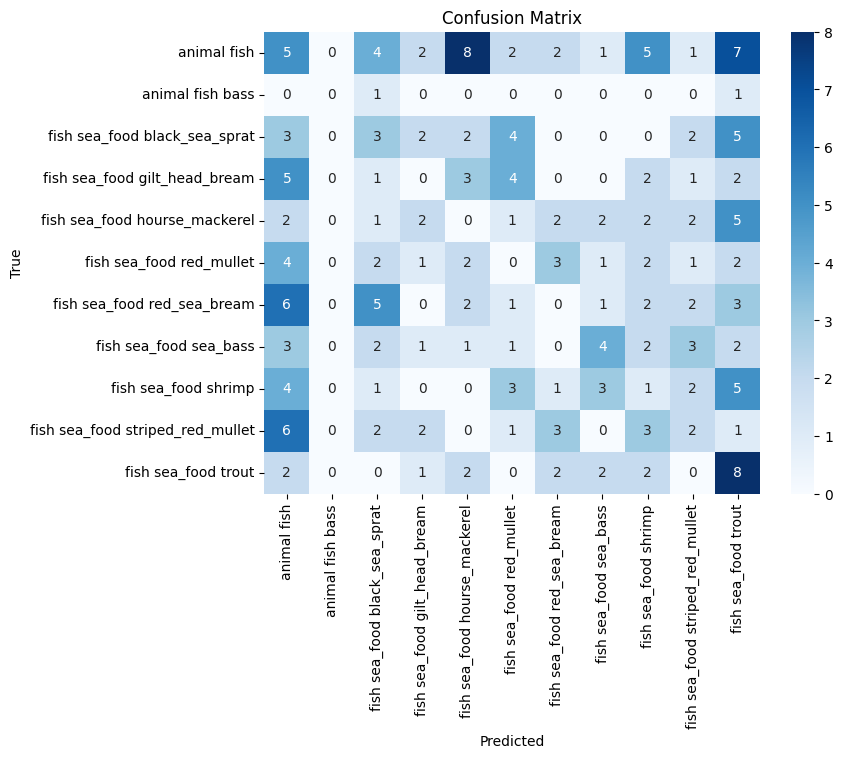


Training VGG16 model...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2825 - loss: 2.0879
Epoch 1: val_accuracy improved from None to 0.65581, saving model to models/vgg16_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1423s 9s/step - accuracy: 0.3656 - loss: 1.7861 - val_accuracy: 0.6558 - val_loss: 1.1711
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4823 - loss: 1.4079
Epoch 2: val_accuracy improved from 0.65581 to 0.77209, saving model to models/vgg16_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1026s 7s/step - accuracy: 0.5068 - loss: 1.3461 - val_accuracy: 0.7721 - val_loss: 0.9148
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5628 - loss: 1.1869
Epoch 3: val_accuracy improved from 0.77209 to 0.88372, saving model to models/vgg16_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1024s 7s/step - accuracy: 0.5809 - loss: 1.1383 - val_accuracy: 0.8837 - val_loss: 0.6915
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6258 - loss: 1.0398
Epoch 4: val_accuracy did not improve from 0.88372
156/156 ━━━━━━━━━━━━━━━━━━━━ 1028s 7s/step - accuracy: 0.6324 - loss: 1.0083 - val_accuracy: 0.8791 - val_loss: 0.6272
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6315 - loss: 0.9773
Epoch 5: val_accuracy did not improve from 0.88372
156/156 ━━━━━━━━━━━━━━━━━━━━ 1028s 7s/step - accuracy: 0.6318 - loss: 0.9744 - val_accuracy: 0.8419 - val_loss: 0.5587


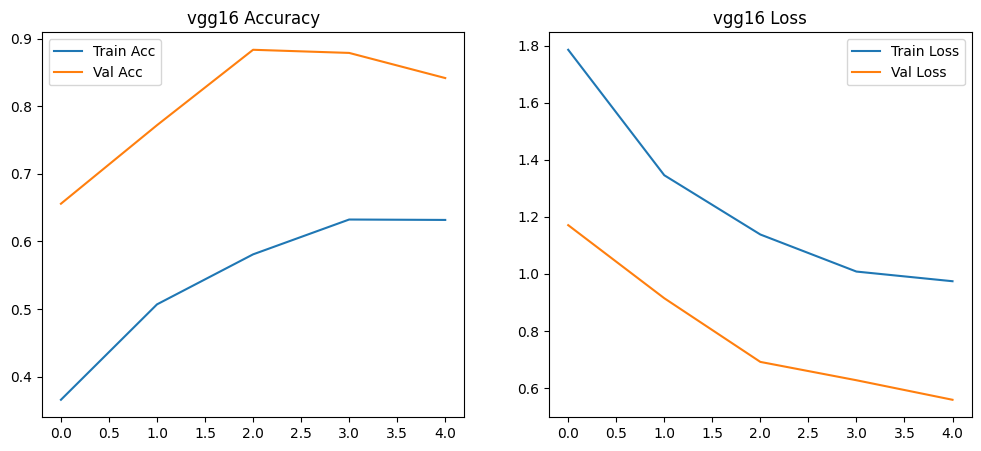

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8651 - loss: 0.5636
Validation Accuracy: 0.8651


7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.13      0.14      0.13        37
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.09      0.10      0.09        21
   fish sea_food gilt_head_bream       0.10      0.11      0.10        18
   fish sea_food hourse_mackerel       0.05      0.05      0.05        19
        fish sea_food red_mullet       0.10      0.17      0.12        18
     fish sea_food red_sea_bream       0.10      0.09      0.09        22
          fish sea_food sea_bass       0.00      0.00      0.00        19
            fish sea_food shrimp       0.05      0.05      0.05        20
fish sea_food striped_red_mullet       0.12      0.05      0.07        20
             fish sea_food trout       0.00      0.00      0.00        19

                        accuracy                 

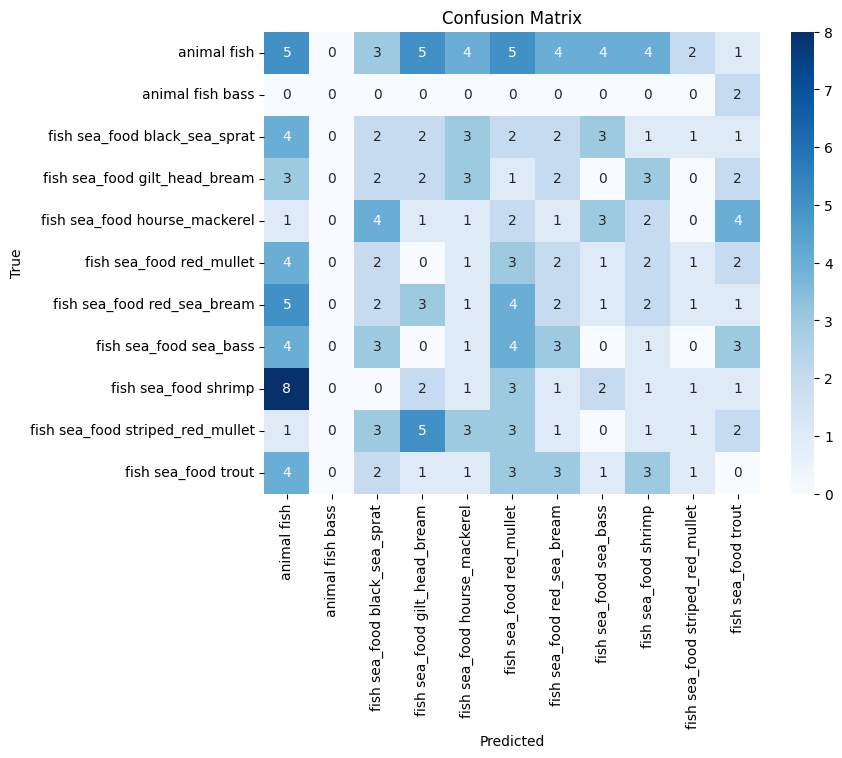


Training ResNet50 model...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1314 - loss: 3.2444
Epoch 1: val_accuracy improved from None to 0.17209, saving model to models/resnet50_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.1567 - loss: 2.6090 - val_accuracy: 0.1721 - val_loss: 2.3878
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1671 - loss: 2.3907
Epoch 2: val_accuracy did not improve from 0.17209
156/156 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.1766 - loss: 2.3900 - val_accuracy: 0.1721 - val_loss: 2.3783
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1770 - loss: 2.3748 
Epoch 3: val_accuracy did not improve from 0.17209
156/156 ━━━━━━━━━━━━━━━━━━━━ 1778s 11s/step - accuracy: 0.1760 - loss: 2.3727 - val_accuracy: 0.1721 - val_loss: 2.3699
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1830 - loss: 2.3644
Epoch 4: val_accuracy did not improve from 0.17209
156/156 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.1762 - loss: 2.3661 - val_accuracy: 0.1721 - val_loss: 2.3627
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1711 - loss: 2.3606
Epoch 5: val_accuracy did not impro

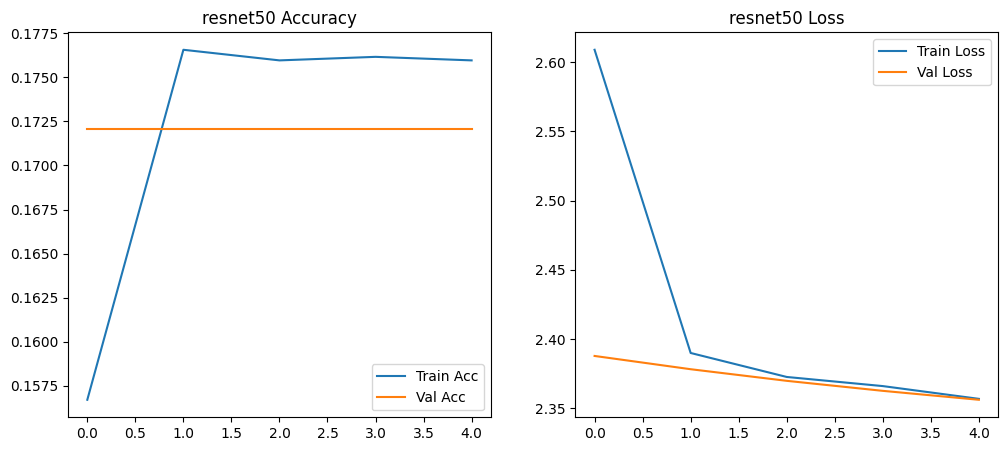

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1721 - loss: 2.3562
Validation Accuracy: 0.1721
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.17      1.00      0.29        37
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.00      0.00      0.00        21
   fish sea_food gilt_head_bream       0.00      0.00      0.00        18
   fish sea_food hourse_mackerel       0.00      0.00      0.00        19
        fish sea_food red_mullet       0.00      0.00      0.00        18
     fish sea_food red_sea_bream       0.00      0.00      0.00        22
          fish sea_food sea_bass       0.00      0.00      0.00        19
            fish sea_food shrimp       0.00      0.00      0.00        20
fish sea_food striped_red_mullet       0.00      0.00      0.00        20
             fish sea_foo

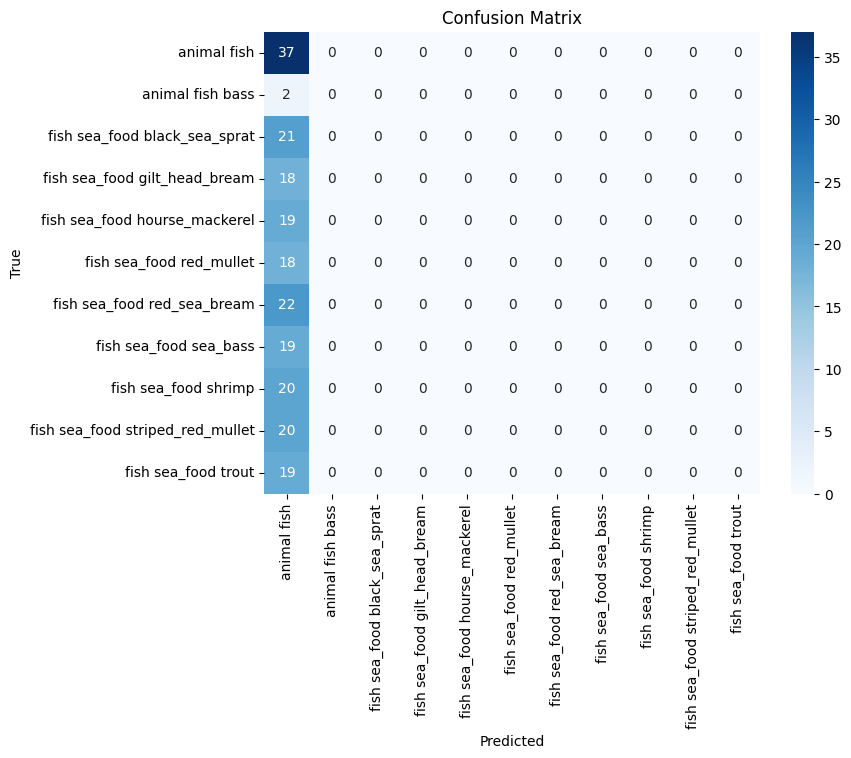


Training MobileNetV2 model...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.3925 - loss: 2.8504
Epoch 1: val_accuracy improved from None to 0.78605, saving model to models/mobilenetv2_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.5080 - loss: 1.7185 - val_accuracy: 0.7860 - val_loss: 0.6773
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.6289 - loss: 1.0811
Epoch 2: val_accuracy improved from 0.78605 to 0.87907, saving model to models/mobilenetv2_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.6541 - loss: 0.9914 - val_accuracy: 0.8791 - val_loss: 0.3877
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.7096 - loss: 0.8314
Epoch 3: val_accuracy improved from 0.87907 to 0.93023, saving model to models/mobilenetv2_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 156s 998ms/step - accuracy: 0.6996 - loss: 0.8288 - val_accuracy: 0.9302 - val_loss: 0.2992
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.7246 - loss: 0.7909
Epoch 4: val_accuracy did not improve from 0.93023
156/156 ━━━━━━━━━━━━━━━━━━━━ 154s 989ms/step - accuracy: 0.7201 - loss: 0.7893 - val_accuracy: 0.9070 - val_loss: 0.3674
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.7185 - loss: 0.7375
Epoch 5: val_accuracy did not improve from 0.93023
156/156 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7173 - loss: 0.7350 - val_accuracy: 0.9116 - val_loss: 0.3180


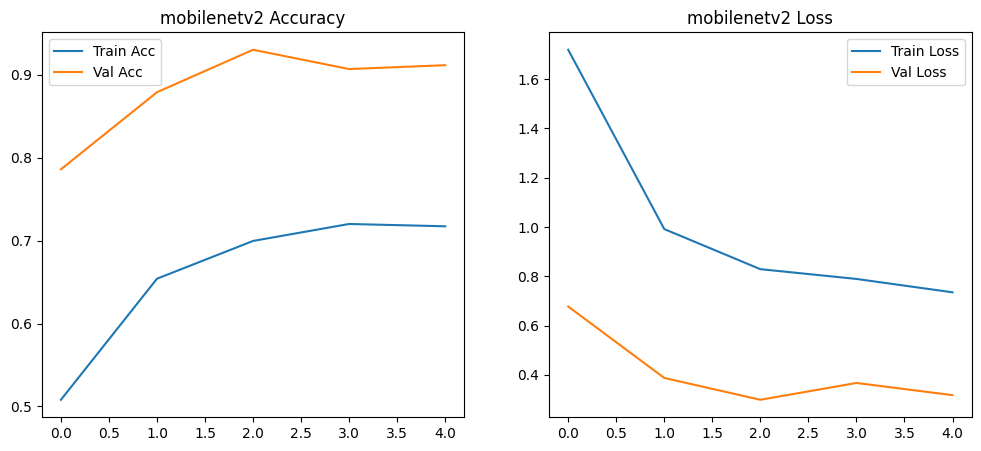

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 831ms/step - accuracy: 0.8930 - loss: 0.3631
Validation Accuracy: 0.8930
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.32      0.32      0.32        37
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.17      0.19      0.18        21
   fish sea_food gilt_head_bream       0.05      0.06      0.05        18
   fish sea_food hourse_mackerel       0.00      0.00      0.00        19
        fish sea_food red_mullet       0.05      0.06      0.05        18
     fish sea_food red_sea_bream       0.06      0.05      0.05        22
          fish sea_food sea_bass       0.00      0.00      0.00        19
            fish sea_food shrimp       0.05      0.05      0.05        20
fish sea_food striped_red_mullet       0.06      0.05      0.05        20
             fish sea_

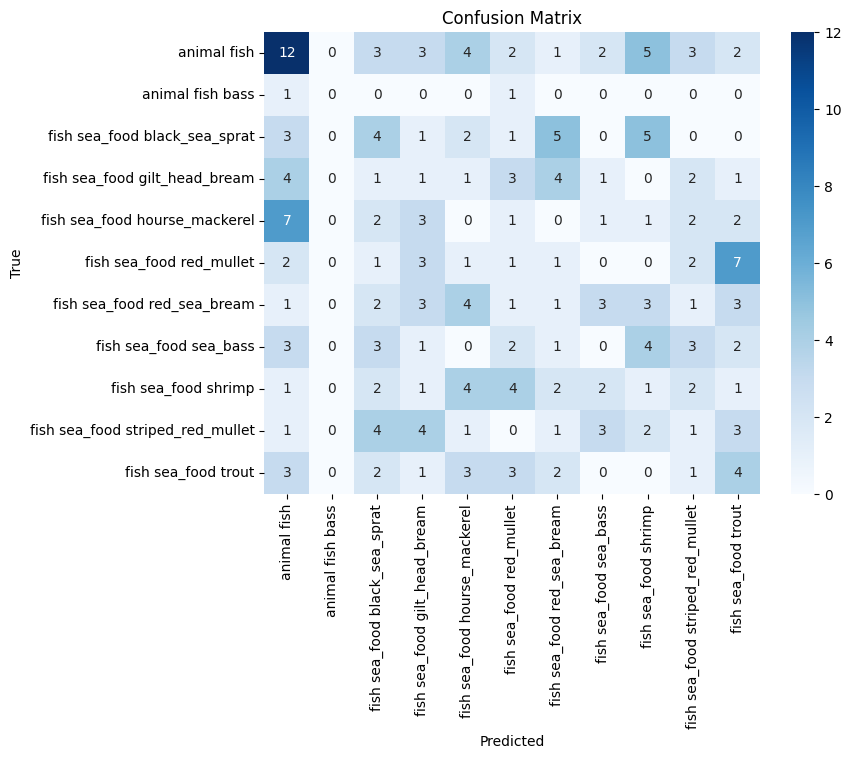


Training InceptionV3 model...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2342 - loss: 4.0870
Epoch 1: val_accuracy improved from None to 0.49767, saving model to models/inceptionv3_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.2879 - loss: 2.4796 - val_accuracy: 0.4977 - val_loss: 1.5924
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3685 - loss: 1.7677
Epoch 2: val_accuracy improved from 0.49767 to 0.65116, saving model to models/inceptionv3_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.4047 - loss: 1.6979 - val_accuracy: 0.6512 - val_loss: 1.1850
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3976 - loss: 1.6550
Epoch 3: val_accuracy improved from 0.65116 to 0.75349, saving model to models/inceptionv3_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.4073 - loss: 1.6310 - val_accuracy: 0.7535 - val_loss: 1.0227
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4269 - loss: 1.5709
Epoch 4: val_accuracy improved from 0.75349 to 0.81395, saving model to models/inceptionv3_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.4344 - loss: 1.5525 - val_accuracy: 0.8140 - val_loss: 0.9923
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4648 - loss: 1.5067
Epoch 5: val_accuracy did not improve from 0.81395
156/156 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.4617 - loss: 1.5060 - val_accuracy: 0.8047 - val_loss: 0.9592


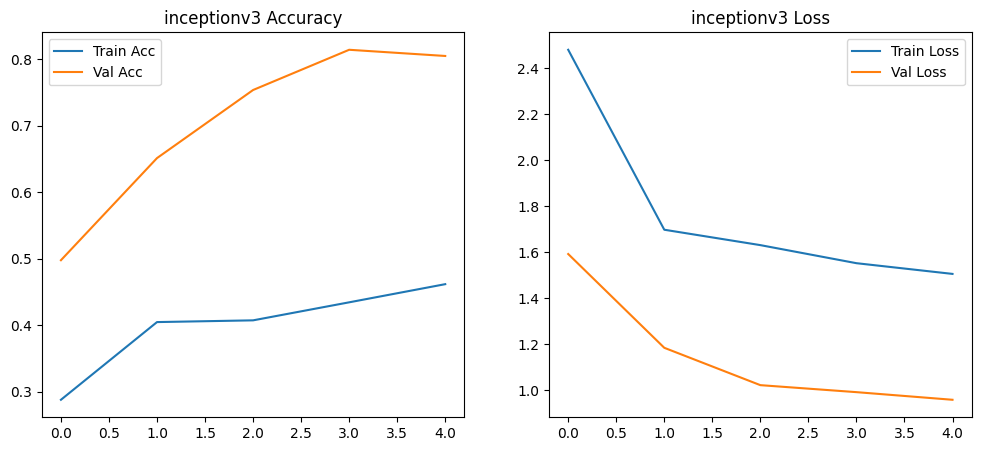

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7953 - loss: 0.9723
Validation Accuracy: 0.7953
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.09      0.08      0.08        37
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.00      0.00      0.00        21
   fish sea_food gilt_head_bream       0.22      0.11      0.15        18
   fish sea_food hourse_mackerel       0.08      0.11      0.09        19
        fish sea_food red_mullet       0.00      0.00      0.00        18
     fish sea_food red_sea_bream       0.18      0.27      0.22        22
          fish sea_food sea_bass       0.10      0.11      0.10        19
            fish sea_food shrimp       0.24      0.25      0.24        20
fish sea_food striped_red_mullet       0.24      0.20      0.22        20
             fish sea_foo

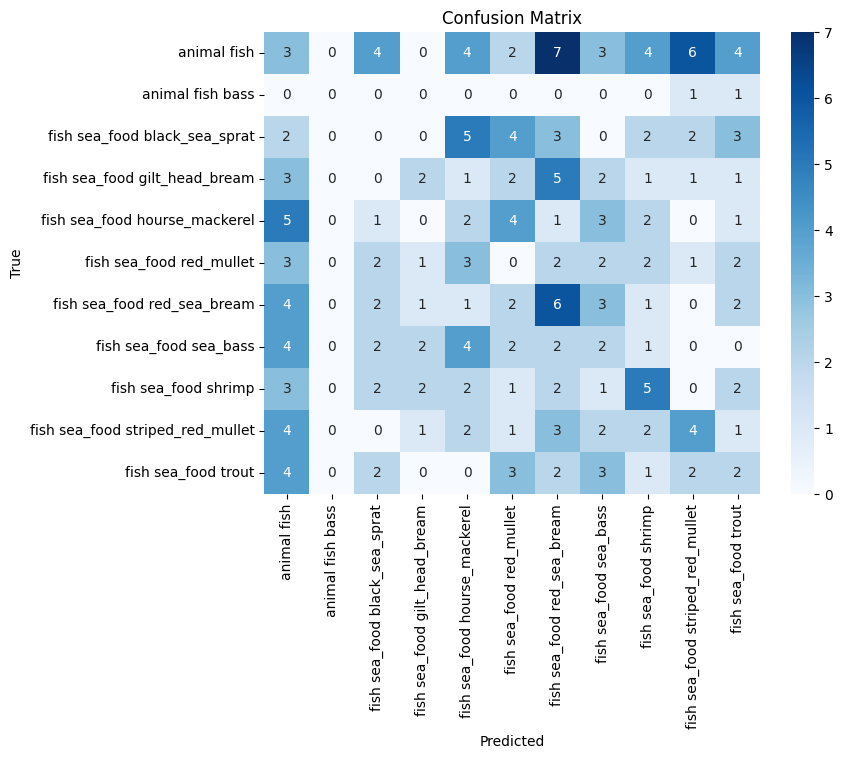


Training EfficientNetB0 model...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1338 - loss: 3.4634
Epoch 1: val_accuracy improved from None to 0.17209, saving model to models/efficientnetb0_best.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.1549 - loss: 2.6465 - val_accuracy: 0.1721 - val_loss: 2.3882
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1730 - loss: 2.3865
Epoch 2: val_accuracy did not improve from 0.17209
156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.1756 - loss: 2.3842 - val_accuracy: 0.1721 - val_loss: 2.3787
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1778 - loss: 2.3769
Epoch 3: val_accuracy did not improve from 0.17209
156/156 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.1760 - loss: 2.3783 - val_accuracy: 0.1721 - val_loss: 2.3704
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1782 - loss: 2.3661
Epoch 4: val_accuracy did not improve from 0.17209
156/156 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.1760 - loss: 2.3646 - val_accuracy: 0.1721 - val_loss: 2.3629
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1786 - loss: 2.3582
Epoch 5: val_accuracy did not improve f

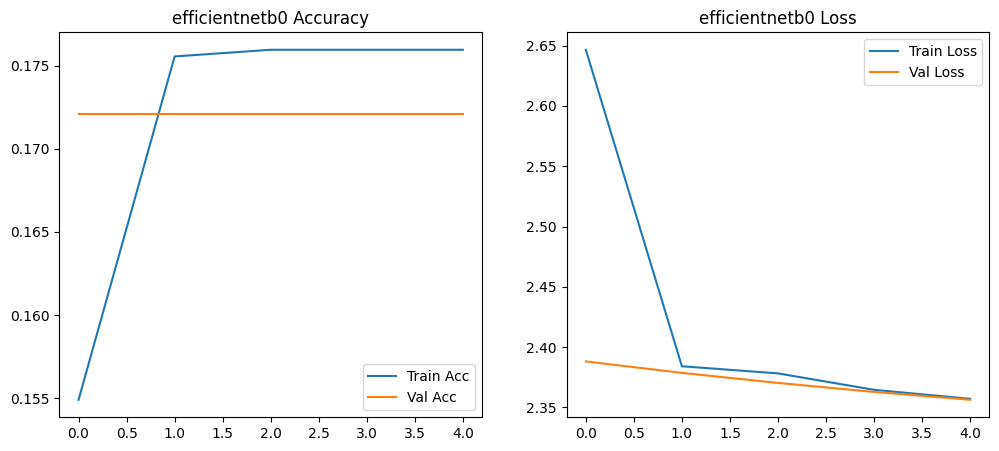

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 907ms/step - accuracy: 0.1721 - loss: 2.3564
Validation Accuracy: 0.1721
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step 

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.17      1.00      0.29        37
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.00      0.00      0.00        21
   fish sea_food gilt_head_bream       0.00      0.00      0.00        18
   fish sea_food hourse_mackerel       0.00      0.00      0.00        19
        fish sea_food red_mullet       0.00      0.00      0.00        18
     fish sea_food red_sea_bream       0.00      0.00      0.00        22
          fish sea_food sea_bass       0.00      0.00      0.00        19
            fish sea_food shrimp       0.00      0.00      0.00        20
fish sea_food striped_red_mullet       0.00      0.00      0.00        20
             fish sea_

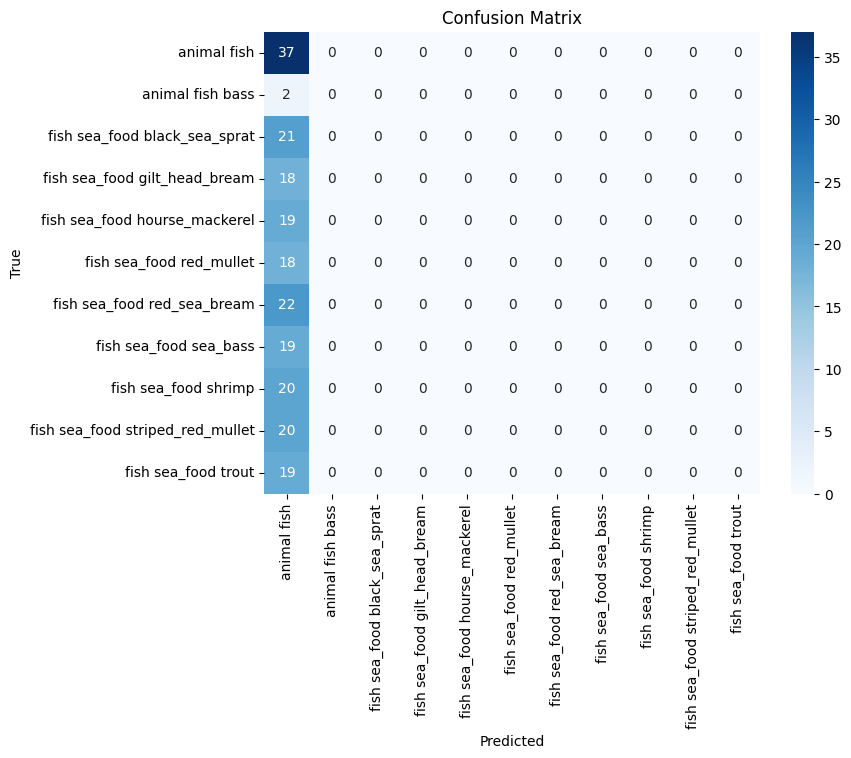

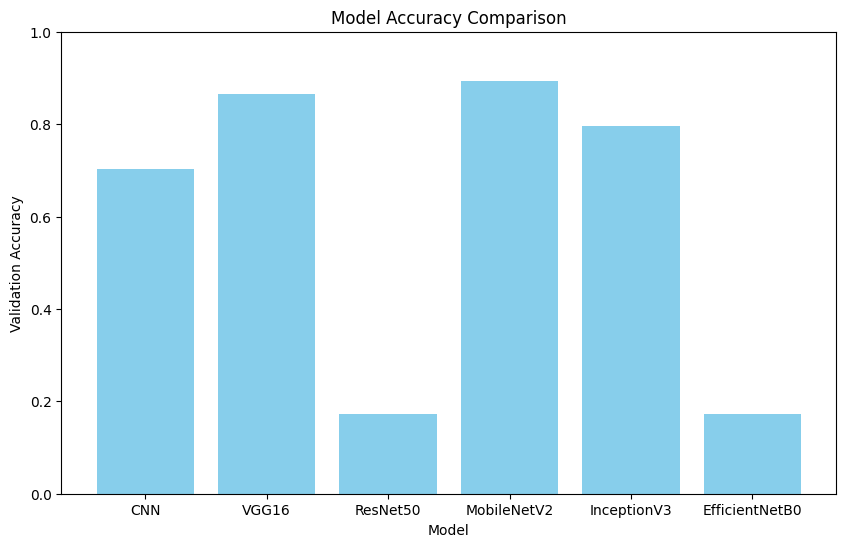


Best Model: MobileNetV2 (89.30% accuracy)



Fine-tuning MobileNetV2...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.5692 - loss: 2.6453 - val_accuracy: 0.9116 - val_loss: 0.3034
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7221 - loss: 0.8141 - val_accuracy: 0.9116 - val_loss: 0.3309
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.7384 - loss: 0.7010 - val_accuracy: 0.9070 - val_loss: 0.2875
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.7436 - loss: 0.6961 - val_accuracy: 0.9488 - val_loss: 0.1926
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.7570 - loss: 0.6348 - val_accuracy: 0.9488 - val_loss: 0.2100


Fine-tuned model saved as final_best_model_finetuned.h5


In [19]:
# This runs the entire process:
# 1. Loads and augments data
# 2. Trains all models
# 3. Evaluates and compares performance
# 4. Fine-tunes the best model

if __name__ == "__main__":
    train_gen, val_gen = create_data_generators('data/train', 'data/val')
    results = compare_models(train_gen, val_gen)